Model fitting 2: SSC + galaxy template
======================================


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
print(jetset.__version__)

1.2.0rc13


In [3]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [4]:
data=Data.from_file(test_SEDs[3])



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



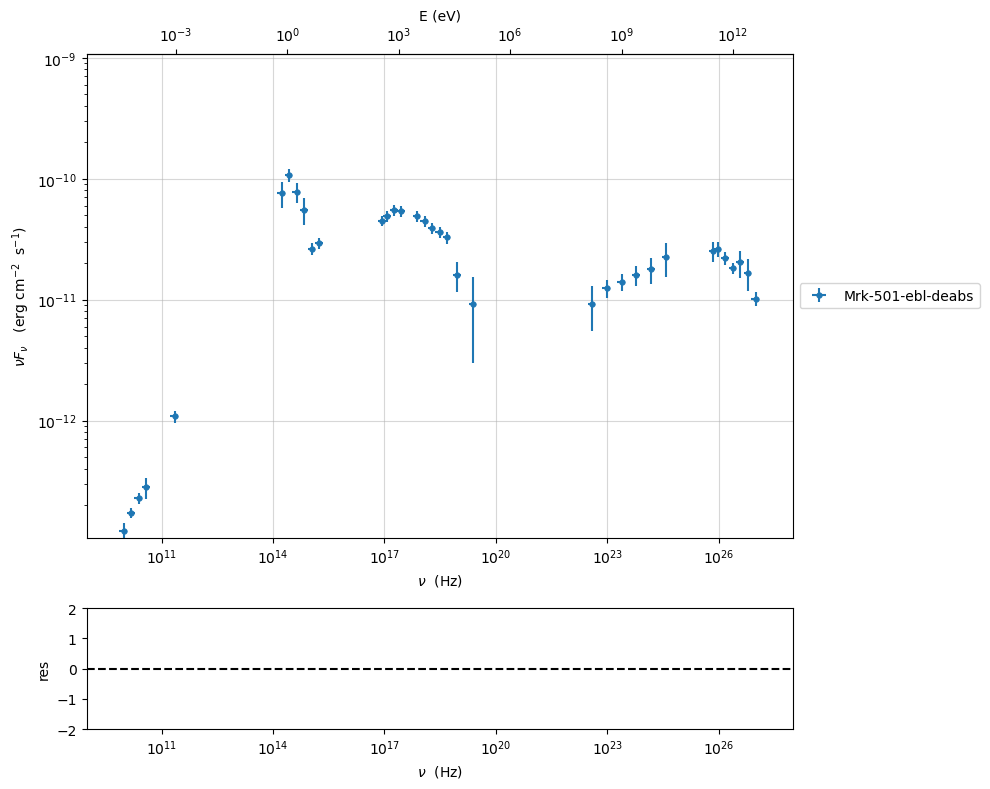

In [5]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [6]:
sed_data.save('Mrk_501.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



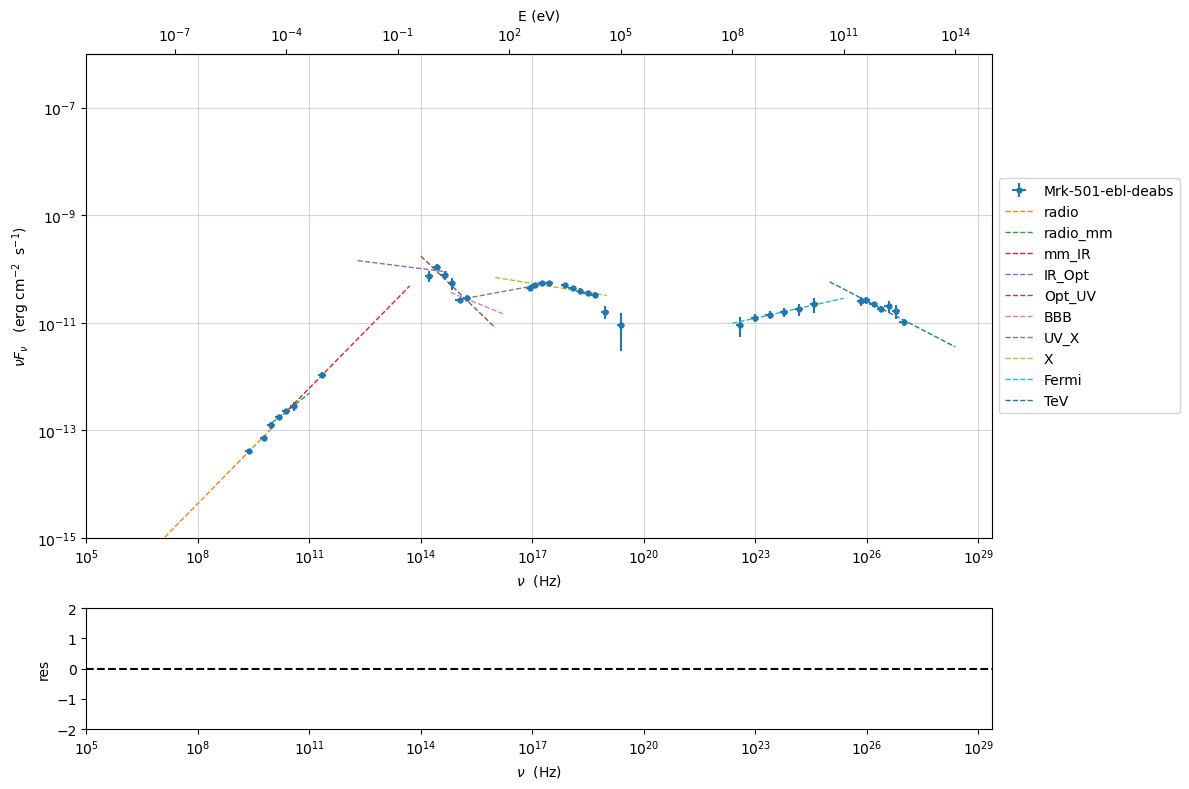

In [7]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=1E-6)

### Sed shaper

In [8]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10. , 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.411143e-02,-6.411143e-02,7.838958e-03,--,-4.778764e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.751705e-03,-1.751705e-03,1.127020e-03,--,3.576201e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.703747e+01,1.703747e+01,9.437333e-02,--,1.626870e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030068e+01,-1.030068e+01,1.884116e-02,--,-1.025412e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.006556e+01,-1.006556e+01,5.462500e-02,--,-1.025412e+01,-1.225412e+01,-8.254123e+00,False
host_galaxy,nu_scale,1.730750e-02,1.730750e-02,3.694838e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.703747e+01 (err=+9.437333e-02)  nuFnu_p=-1.030068e+01 (err=+1.884116e-02) curv.=-6.411143e-02 (err=+7.838958e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.310993e-01,-1.310993e-01,3.244183e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-3.300446e-02,-3.300446e-02,2.072517e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.549603e+01,2.549603e+01,2.235468e-01,--,2.556357e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.057945e+01,-1.057945e+01,4.332976e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.549603e+01 (err=+2.235468e-01)  nuFnu_p=-1.057945e+01 (err=+4.332976e-02) curv.=-1.310993e-01 (err=+3.244183e-02)



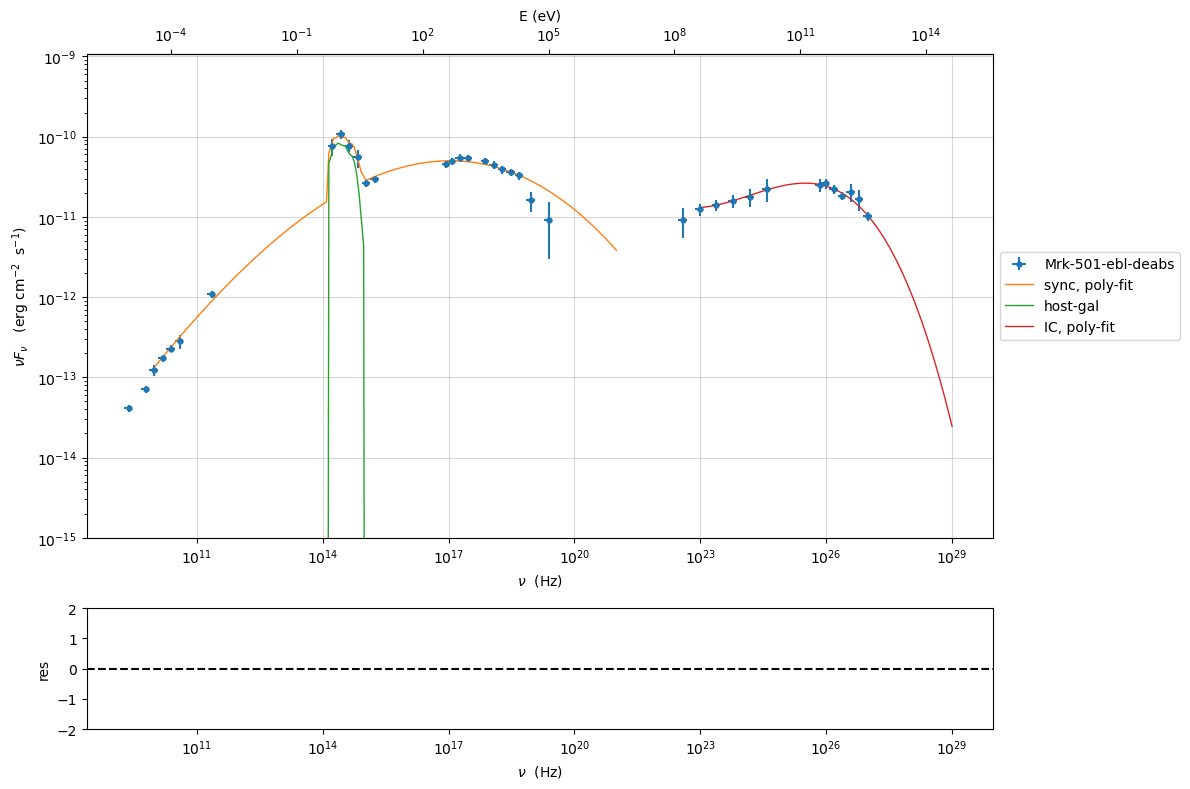

In [9]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [10]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


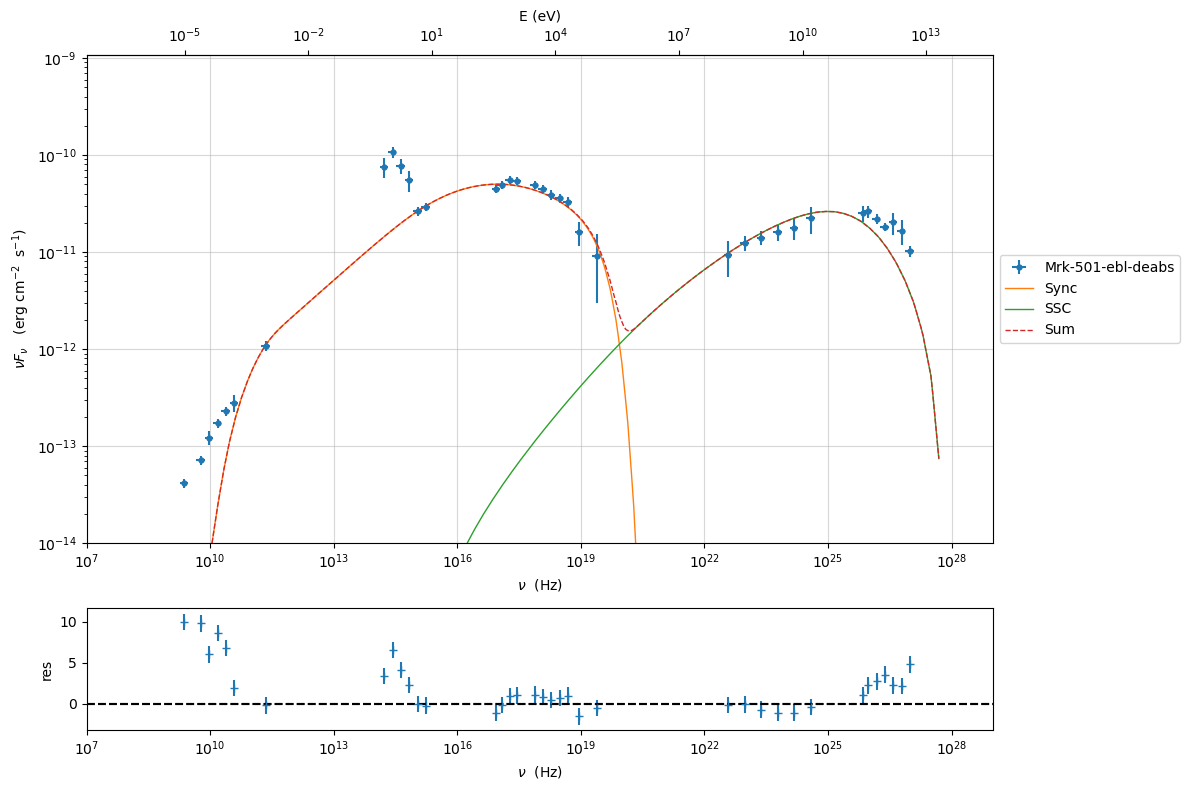

In [11]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-14,x_min=1E7,x_max=1E29)

## Model fitting

### Model fitting with LSB

In [12]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205571e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [13]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 
fit_model_lsb.show_model()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
jet model description
--------------------------------------------------------------------------------
name: jet_leptonic  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 1.487509e+02
 gmax grid : 2.310708e+06
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: o

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205571e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
model description
--------------------------------------------------------------------------------
name: host_galaxy  
type: template  

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
host_galaxy,nuFnu_p_host,nuFnu-scale,erg / (cm2 s),-1.006556e+01,-2.000000e+01,2.000000e+01,False,False
host_galaxy,nu_scale,nu-scale,Hz,1.730750e-02,-2.000000e+00,2.000000e+00,False,False


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [14]:
fit_model_lsb.composite_expr='jet_leptonic + host_galaxy '

In [15]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [16]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=8.37724e+00

fit run: 1
- old chisq=8.37724e+00


0it [00:00, ?it/s]

- best chisq=8.27149e+00

fit run: 2
- old chisq=8.27149e+00


0it [00:00, ?it/s]

- best chisq=8.20543e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,9.979718e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.027394e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.497564e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.875701e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.163916e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.218463e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.335860e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.222382e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.467144e+01,1.000000e-04,--,False,False



converged=True
calls=75
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=8.205429, chisq/red=0.390735 null hypothesis sig=0.994210

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,9.979718e+01,9.979718e+01,1.973688e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.027394e+06,2.027394e+06,1.339381e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.497564e+01,2.497564e+01,7.243329e+01,--,3.082271e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.875701e+03,4.875701e+03,1.519095e+04,--,1.045836e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.163916e+00,2.163916e+00,4.165962e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.218463e-01,2.218463e-01,4.038740e-02,--,3.205571e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.335860e+16,1.335860e+16,2.449660e+16,--,1.046428e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.222382e-02,1.222382e-02,8.321098e-03,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.467144e+01,4.467144e+01,2.951759e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




In [17]:
best_fit_lsb.save_report('SSC-best-fit-lsb.pkl')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.979718e+01,9.979718e+01,1.973688e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.027394e+06,2.027394e+06,1.339381e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.497564e+01,2.497564e+01,7.243329e+01,--,3.082271e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.875701e+03,4.875701e+03,1.519095e+04,--,1.045836e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.163916e+00,2.163916e+00,4.165962e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.218463e-01,2.218463e-01,4.038740e-02,--,3.205571e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.335860e+16,1.335860e+16,2.449660e+16,--,1.046428e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.222382e-02,1.222382e-02,8.321098e-03,--,5.050000e-02,0.000000e+00,--,False


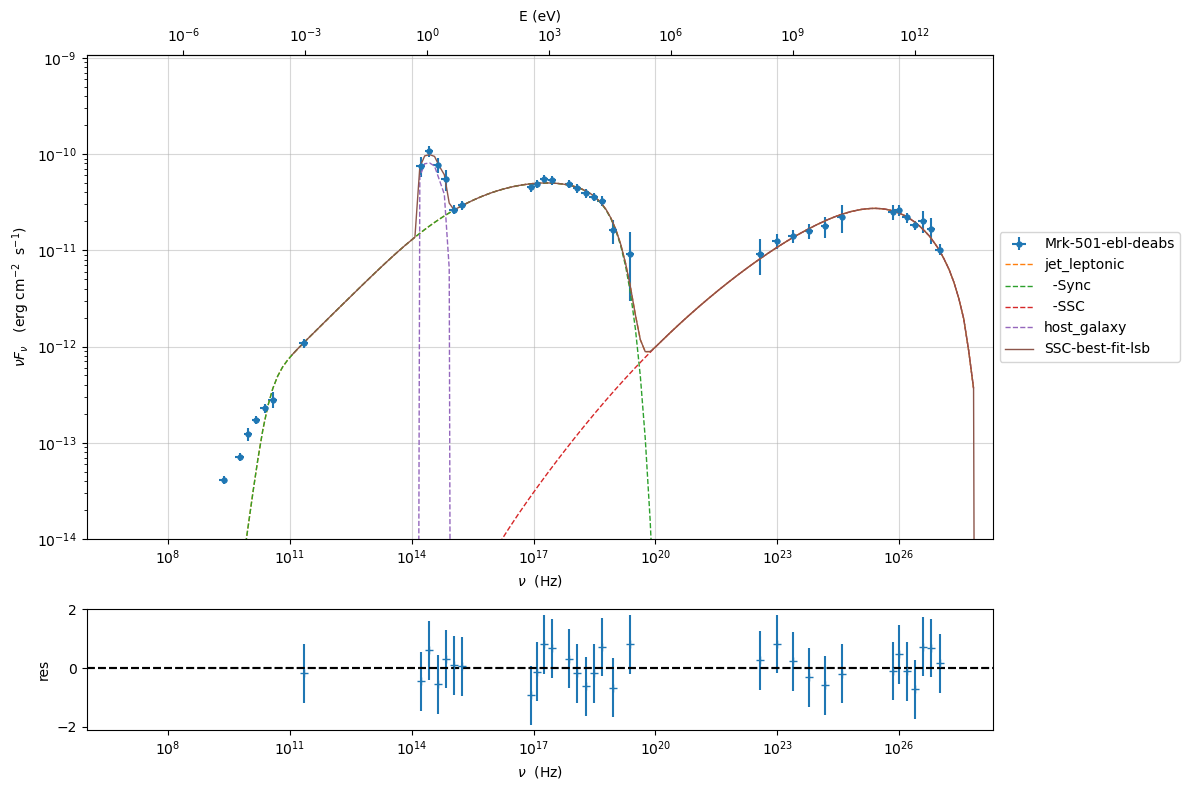

In [18]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

### Model fitting with Minuit

In [19]:
jet_minuit=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_minuit.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205571e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


To run the ``minuit`` minimizer we will use the best-fit results from ``lsb`` to set the boundaries for our parameters. 

In [20]:
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=my_shape.host_gal) 
fit_model_minuit.show_model_components()
fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,5E5]

model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-minuit',repeat=3)


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=8.12554e+00

fit run: 1
- old chisq=8.12554e+00


0it [00:00, ?it/s]

- best chisq=8.12546e+00

fit run: 2
- old chisq=8.12546e+00


0it [00:00, ?it/s]

- best chisq=8.12543e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,7.837482e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.168678e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.553272e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.124494e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.115881e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.090576e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.530522e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.099348e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.413328e+01,1.000000e-04,--,False,False



converged=True
calls=196
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.125                      │              Nfcn = 196              │
│ EDM = 0.000148 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │    78     │     8     │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  2.17e6   │  0.04e6   │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │   25.5    │    2.0    │            │            │    0    │         │       │
│ 3 │ par_3 │   3.1e3   │   0.4e3   │            │            │  1000   │ 500000  │       │
│ 4 │ par_4 │   2.116   │   0.017   │            │            │   -10   │   10    │       │
│ 5 │ par_5 │   0.209   │   0.008   │            │            │   -15   │   15    │       │
│ 6 │ par_6 │  15.3e15  │  0.7e15   │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │  11.0e-3  │  0.6e-3   │            │            │    0    │         │       │
│ 8 │ par_8 │   44.1    │    1.1    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.06   │   0.05    │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9 │
├───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ par_0 │      61.3  2.83e+05     -6.49  1.19e+03    0.0606    0.0279 -4.01e+15   0.00477     -3.79  -0.00799 │
│ par_1 │  2.83e+05  1.49e+09 -2.96e+04  5.54e+06       282       128 -1.85e+19      21.4 -1.66e+04     -34.8 │
│ par_2 │     -6.49 -2.96e+04      4.01      85.2   0.00939  -0.00219 -3.45e+13 -0.000505     0.515   0.00106 │
│ par_3 │  1.19e+03  5.54e+06      85.2  1.94e+05      5.33      2.36 -9.98e+16    0.0937     -90.9    0.0499 │
│ par_4 │    0.0606       282   0.00939      5.33  0.000273  4.51e-05 -4.53e+12  4.64e-06  -0.00244 -1.15e-05 │
│ par_5 │    0.0279       128  -0.00219      2.36  4.51e-05   6.3e-05 -2.11e+12  2.32e-06 -0.000316 -2.11e-05 │
│ par_6 │ -4.01e+15 -1.85e+19 -3.45e+13 -9.98e+16 -4.53e+12 -2.11e+12  4.89e+29 -3.22e+11 -1.38e+13  6.25e+10 │
│ par_7 │   0.00477      21.4 -0.000505    0.0937  4.64e-06  2.32e-06 -3.22e+11  4.05e-07 -0.000327 -7.07e-07 │
│ par_8 │     -3.79 -1.66e+04     0.515     -90.9  -0.00244 -0.000316 -1.38e+13 -0.000327       1.2  -0.00197 │
│ par_9 │  -0.00799     -34.8   0.00106    0.0499 -1.15e-05 -2.11e-05  6.25e+10 -7.07e-07  -0.00197   0.00249 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

dof=21
chisq=8.125430, chisq/red=0.386925 null hypothesis sig=0.994589

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,7.837482e+01,7.837482e+01,7.830642e+00,--,1.487509e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,2.168678e+06,2.168678e+06,3.860903e+04,--,2.310708e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,2.553272e+01,2.553272e+01,2.002717e+00,--,3.082271e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,3.124494e+03,3.124494e+03,4.402149e+02,--,1.045836e+04,1.000000e+03,5.000000e+05,False
jet_leptonic,s,2.115881e+00,2.115881e+00,1.651203e-02,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.090576e-01,2.090576e-01,7.935095e-03,--,3.205571e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.530522e+16,1.530522e+16,6.992587e+14,--,1.046428e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.099348e-02,1.099348e-02,6.367776e-04,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.413328e+01,4.413328e+01,1.096092e+00,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




for further information regardin minuit please refer to https://iminuit.readthedocs.io/en/v1.5.4/

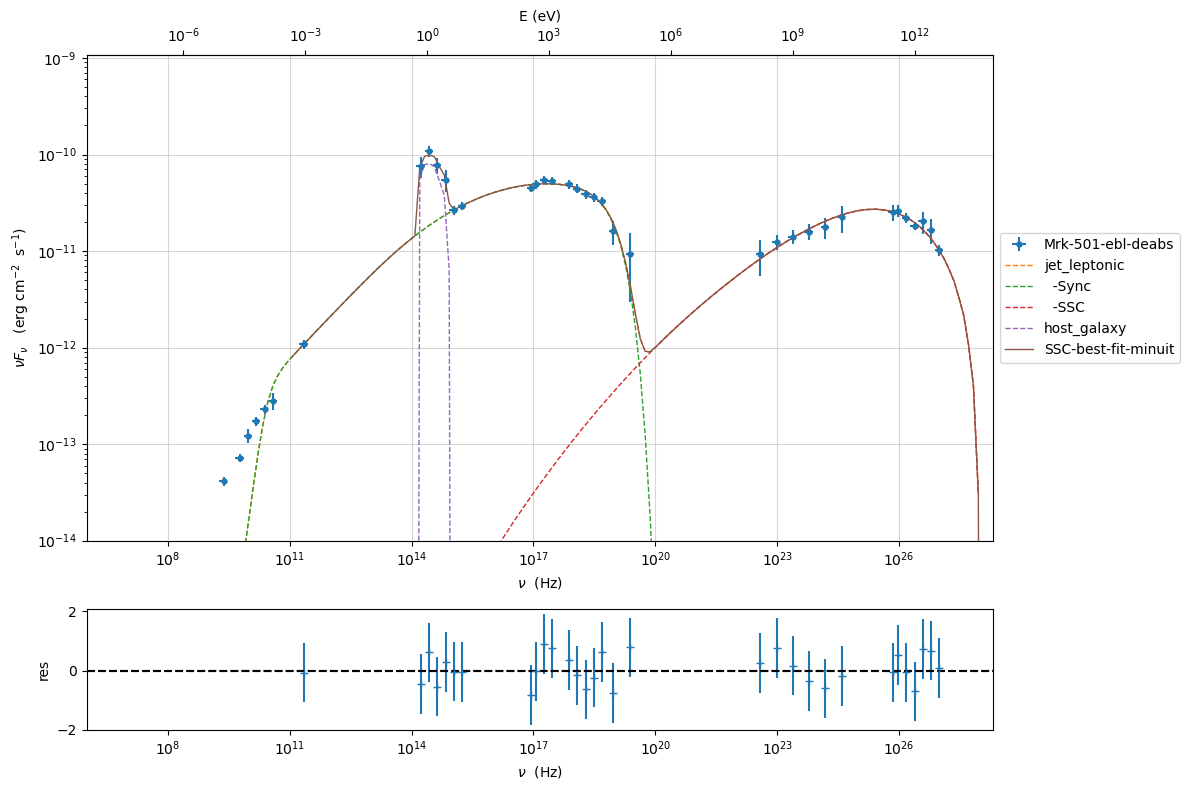

In [21]:
%matplotlib inline
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [22]:
best_fit_minuit.save_report('SSC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.979718e+01,9.979718e+01,1.973688e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.027394e+06,2.027394e+06,1.339381e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.497564e+01,2.497564e+01,7.243329e+01,--,3.082271e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.875701e+03,4.875701e+03,1.519095e+04,--,1.045836e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.163916e+00,2.163916e+00,4.165962e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.218463e-01,2.218463e-01,4.038740e-02,--,3.205571e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.335860e+16,1.335860e+16,2.449660e+16,--,1.046428e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.222382e-02,1.222382e-02,8.321098e-03,--,5.050000e-02,0.000000e+00,--,False


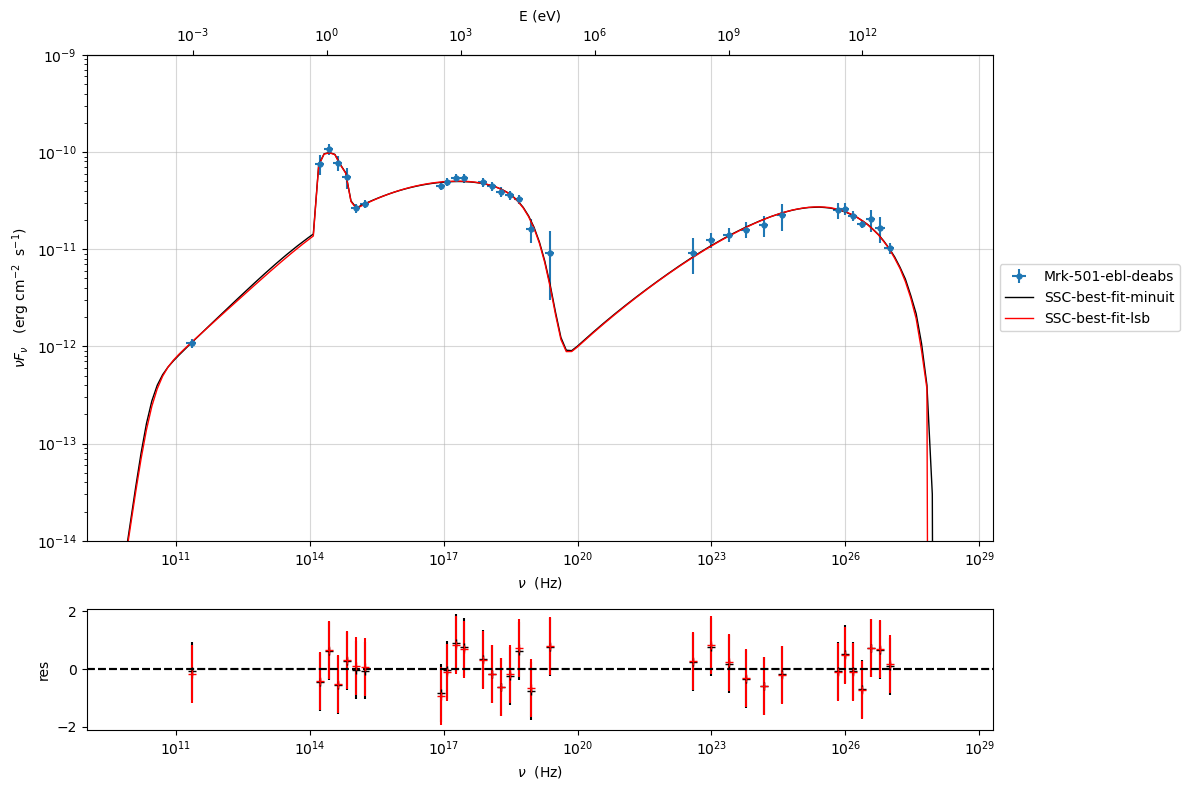

In [33]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 1E11, 1E29])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 1E11, 1E29],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 1E11, 1E29],color='red')
p2.setlim(y_min=1E-14,y_max=1E-9,x_min=1E9,x_max=2E29)

### Model fitting with a bkn pl


In [34]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='bkn',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_bkn_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.092462e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003802e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012034e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


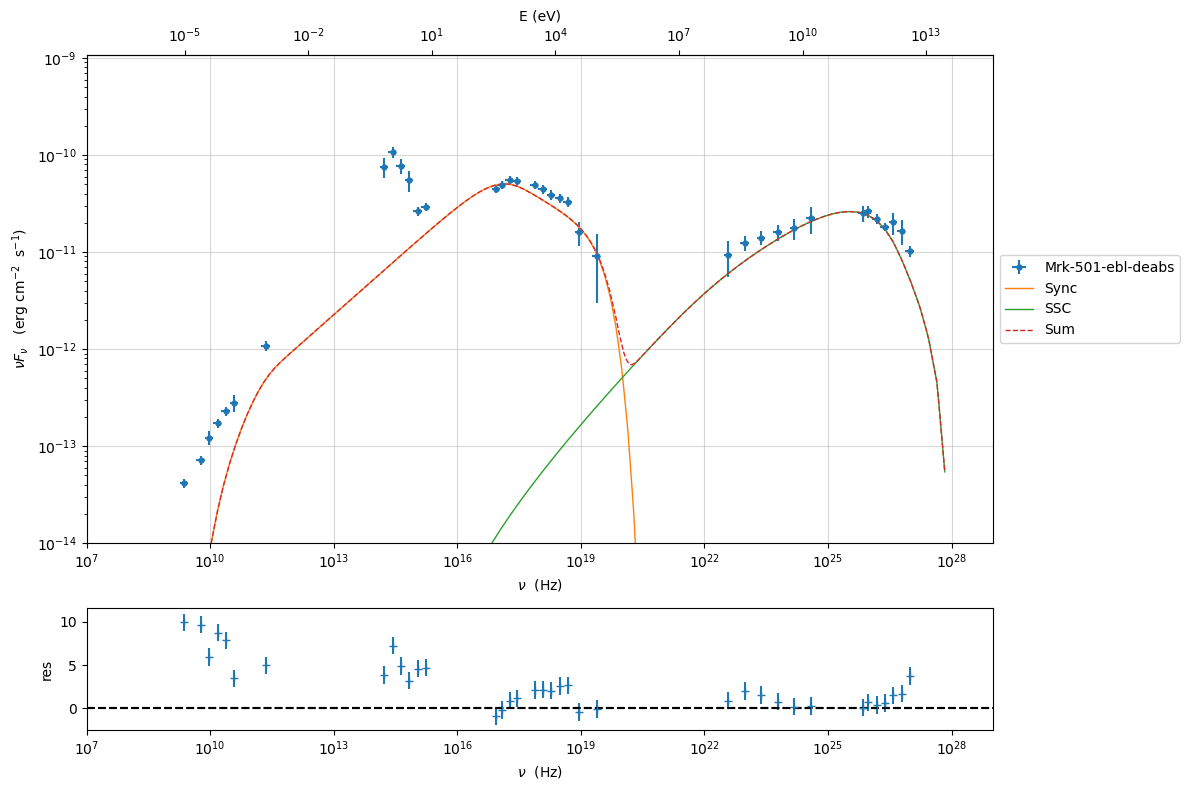

In [35]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-14,x_min=1E7,x_max=1E29)

In [36]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)

fit_model_lsb_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-bkn-lsb',template=my_shape.host_gal) 


fit_model_lsb_bkn.freeze(jet_lsb,'z_cosm')
fit_model_lsb_bkn.freeze(jet_lsb,'R_H')
fit_model_lsb_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_lsb_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb_bkn.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb_bkn.host_galaxy.parameters.nu_scale.frozen=True

model_minimizer_lsb_bkn=ModelMinimizer('lsb')
best_fit_lsb_bkn=model_minimizer_lsb_bkn.fit(fit_model_lsb_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-lsb',repeat=3)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003802e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012034e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092462e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.03828e+01

fit run: 1
- old chisq=1.03828e+01


0it [00:00, ?it/s]

- best chisq=1.03828e+01

fit run: 2
- old chisq=1.03828e+01


0it [00:00, ?it/s]

- best chisq=1.03828e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.535419e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.736794e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.675841e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.524307e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.245760e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.955323e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.362590e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.402504e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.068522e+01,1.000000e-04,--,False,False



converged=True
calls=22
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=10.382757, chisq/red=0.494417 null hypothesis sig=0.973502

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.535419e+02,1.535419e+02,1.172176e+02,--,1.927085e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.736794e+06,1.736794e+06,7.155313e+05,--,2.993548e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,1.675841e+01,1.675841e+01,1.737861e+01,--,2.003802e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.524307e+04,5.524307e+04,3.483584e+04,--,2.012034e+05,1.000000e+00,1.000000e+09,False
jet_leptonic,p,2.245760e+00,2.245760e+00,1.466694e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,p_1,2.955323e+00,2.955323e+00,5.912349e-02,--,3.500000e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,R,1.362590e+16,1.362590e+16,1.380750e+16,--,1.092462e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.402504e-02,1.402504e-02,8.377099e-03,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.068522e+01,4.068522e+01,1.345542e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




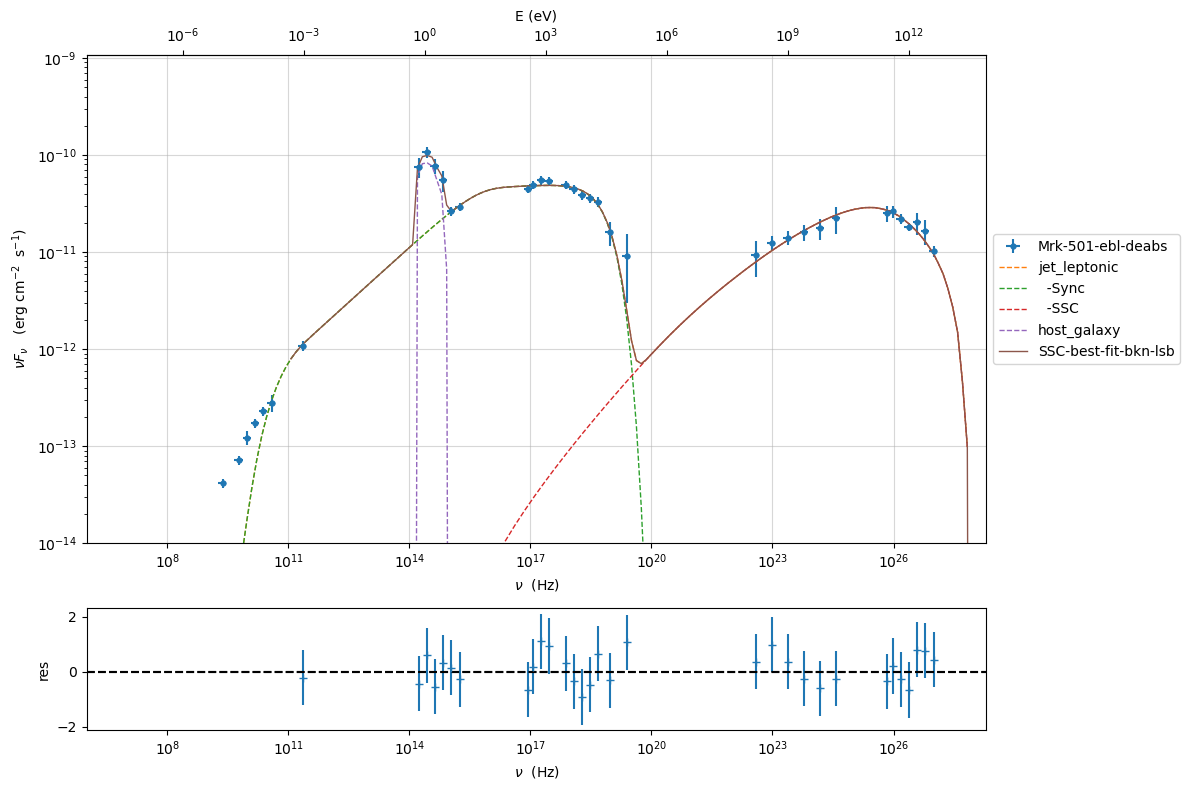

In [37]:
%matplotlib inline
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=fit_model_lsb_bkn.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [38]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)


fit_model_minuit_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-minuit-bkn',template=my_shape.host_gal) 
fit_model_minuit_bkn.show_model_components()
fit_model_minuit_bkn.freeze('jet_leptonic','z_cosm')
fit_model_minuit_bkn.freeze('jet_leptonic','R_H')
fit_model_minuit_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_minuit_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit_bkn.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit_bkn.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit_bkn.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit_bkn.jet_leptonic.parameters.gamma_break.fit_range=[1E3,1E6]
fit_model_minuit_bkn.jet_leptonic.parameters.p.fit_range=[1,3]
fit_model_minuit_bkn.jet_leptonic.parameters.p_1.fit_range=[2,5]


model_minimizer_minuit_bkn=ModelMinimizer('minuit')
best_fit_minuit_bkn=model_minimizer_minuit.fit(fit_model_minuit_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit-bkn',repeat=3)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003802e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012034e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092462e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit-bkn  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.05187e+01

fit run: 1
- old chisq=1.05187e+01


0it [00:00, ?it/s]

- best chisq=1.05186e+01

fit run: 2
- old chisq=1.05186e+01


0it [00:00, ?it/s]

- best chisq=1.05142e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit-bkn


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.187507e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.814606e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.001152e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.668605e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.243450e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.949816e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.531435e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.299676e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,3.968243e+01,1.000000e-04,--,False,False



converged=True
calls=537
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.51                      │              Nfcn = 537              │
│ EDM = 6.68e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │  118.75   │   0.08    │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  1.81e6   │  0.04e6   │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │  20.0115  │  0.0004   │            │            │    0    │         │       │
│ 3 │ par_3 │  56.69e3  │  0.07e3   │            │            │  1000   │  1e+06  │       │
│ 4 │ par_4 │  2.24345  │  0.00018  │            │            │    1    │    3    │       │
│ 5 │ par_5 │  2.9498   │  0.0004   │            │            │    2    │    5    │       │
│ 6 │ par_6 │ 15.314e15 │ 0.006e15  │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │ 12.997e-3 │ 0.009e-3  │            │            │    0    │         │       │
│ 8 │ par_8 │  39.682   │   0.006   │            │            │    5    │   50    │       │
│ 9 │ par_9 │ -10.0492  │  0.0007   │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9 │
├───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ par_0 │   0.00562     -40.3 -4.81e-09   -0.0337  1.08e-07  2.31e-07 -4.29e+09 -6.22e-09  -2.3e-06 -1.31e-09 │
│ par_1 │     -40.3  1.83e+09   -0.0102 -7.25e+04     0.235      0.56 -8.67e+15   -0.0193     -5.07  0.000225 │
│ par_2 │ -4.81e-09   -0.0102  1.45e-07 -4.12e-06  1.32e-11  2.86e-11 -5.25e+05 -7.42e-13 -2.82e-10  -1.6e-13 │
│ par_3 │   -0.0337 -7.25e+04 -4.12e-06  4.85e+03  9.38e-05  0.000212 -3.73e+12 -5.35e-06  -0.00202  3.11e-08 │
│ par_4 │  1.08e-07     0.235  1.32e-11  9.38e-05  3.15e-08 -6.56e-10  1.19e+07  1.71e-11  6.41e-09  2.92e-12 │
│ par_5 │  2.31e-07      0.56  2.86e-11  0.000212 -6.56e-10  1.79e-07  2.62e+07  3.85e-11  1.45e-08 -7.51e-13 │
│ par_6 │ -4.29e+09 -8.67e+15 -5.25e+05 -3.73e+12  1.19e+07  2.62e+07  3.72e+25 -6.85e+05 -2.58e+08 -1.65e+05 │
│ par_7 │ -6.22e-09   -0.0193 -7.42e-13 -5.35e-06  1.71e-11  3.85e-11 -6.85e+05  7.91e-11 -3.75e-10 -2.25e-13 │
│ par_8 │  -2.3e-06     -5.07 -2.82e-10  -0.00202  6.41e-09  1.45e-08 -2.58e+08 -3.75e-10  4.03e-05 -8.22e-11 │
│ par_9 │ -1.31e-09  0.000225  -1.6e-13  3.11e-08  2.92e-12 -7.51e-13 -1.65e+05 -2.25e-13 -8.22e-11  5.33e-07 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

dof=21
chisq=10.514167, chisq/red=0.500675 null hypothesis sig=0.971433

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.187507e+02,1.187507e+02,7.495853e-02,--,1.927085e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,1.814606e+06,1.814606e+06,4.278641e+04,--,2.993548e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,2.001152e+01,2.001152e+01,3.805966e-04,--,2.003802e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.668605e+04,5.668605e+04,6.964003e+01,--,2.012034e+05,1.000000e+03,1.000000e+06,False
jet_leptonic,p,2.243450e+00,2.243450e+00,1.775963e-04,--,2.248787e+00,1.000000e+00,3.000000e+00,False
jet_leptonic,p_1,2.949816e+00,2.949816e+00,4.229235e-04,--,3.500000e+00,2.000000e+00,5.000000e+00,False
jet_leptonic,R,1.531435e+16,1.531435e+16,6.102693e+12,--,1.092462e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.299676e-02,1.299676e-02,8.893765e-06,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,3.968243e+01,3.968243e+01,6.348264e-03,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




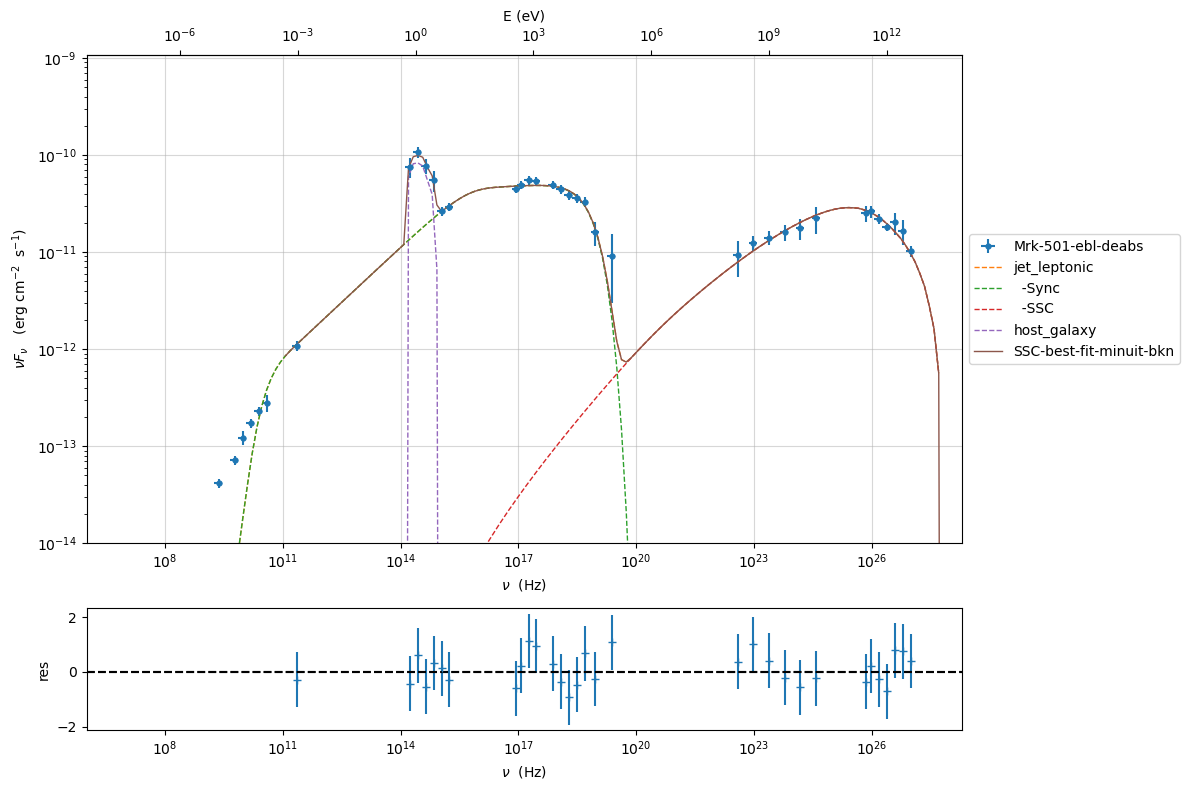

In [39]:
%matplotlib inline
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
p2=fit_model_minuit_bkn.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

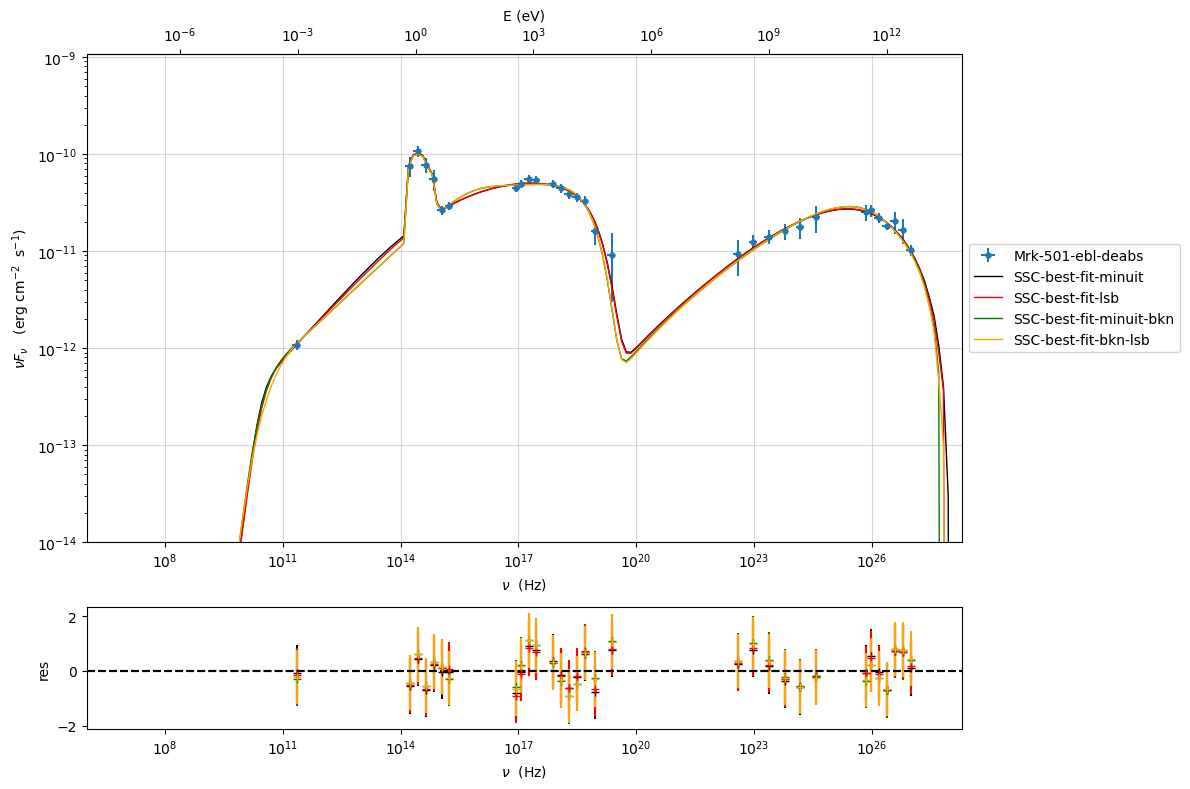

In [41]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 1E11, 1E29])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 1E11, 1E29],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 1E11, 1E29],color='red')
p2.add_model_plot(fit_model_minuit_bkn,color='green')
p2.add_residual_plot(fit_model_minuit_bkn,sed_data,fit_range=[ 1E11, 1E29],color='green')
p2.add_model_plot(fit_model_lsb_bkn,color='orange')
p2.add_residual_plot(fit_model_lsb_bkn,sed_data,fit_range=[ 1E11, 1E29],color='orange')
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

## MCMC sampling

In [42]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used



In [43]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 284.72 seconds


In [44]:
print(mcmc.acceptance_fraction)

0.555625


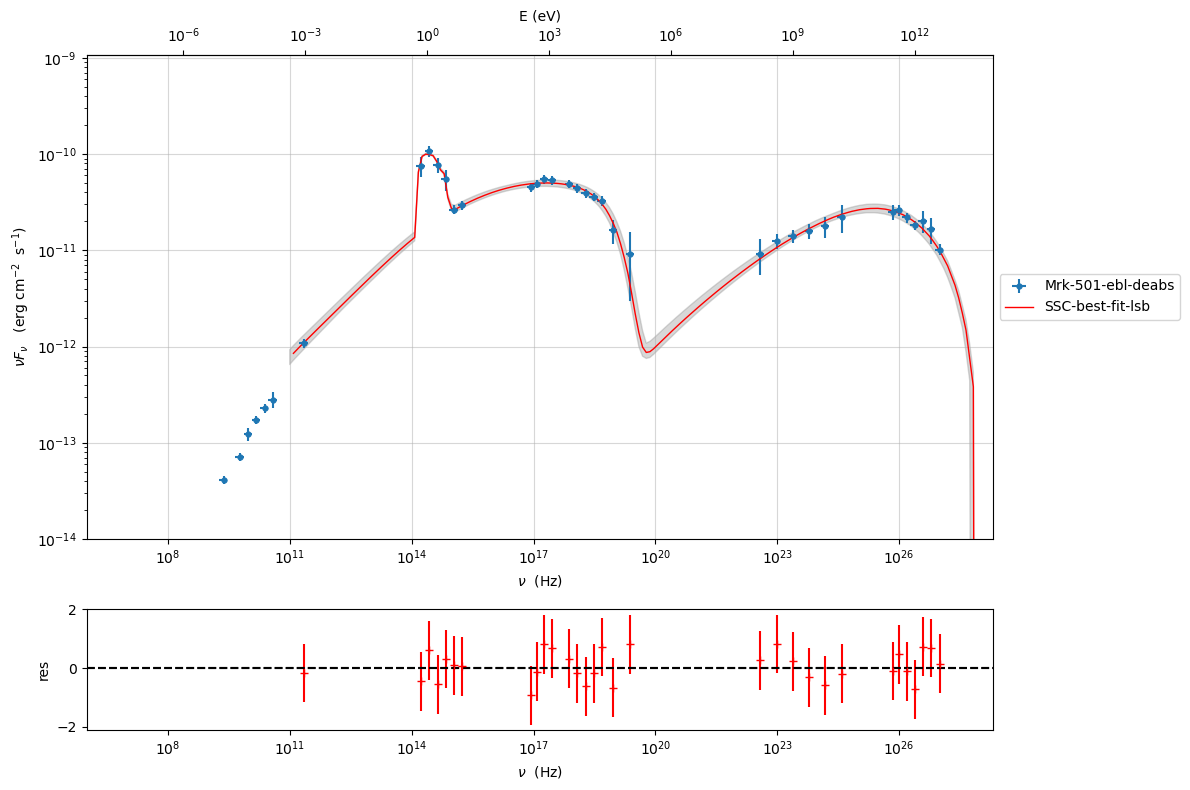

In [45]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11, 2E28],size=50)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

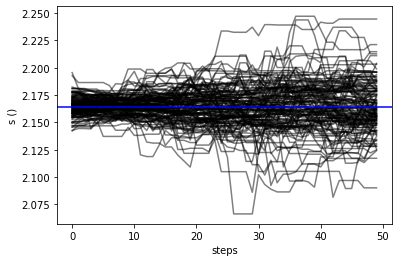

In [46]:
f=mcmc.plot_chain('s',log_plot=False)

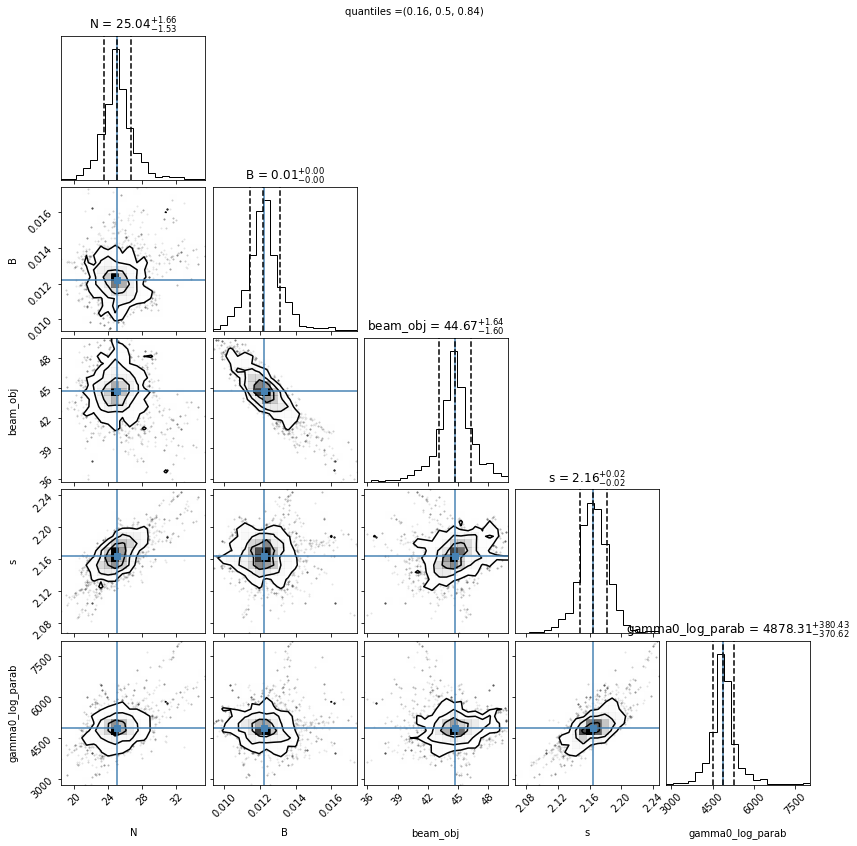

In [47]:
f=mcmc.corner_plot()

In [48]:
mcmc.get_par('N')

(array([25.25952224, 26.17247395, 24.66667642, ..., 24.89107294,
        25.54856039, 23.5643173 ]),
 0)

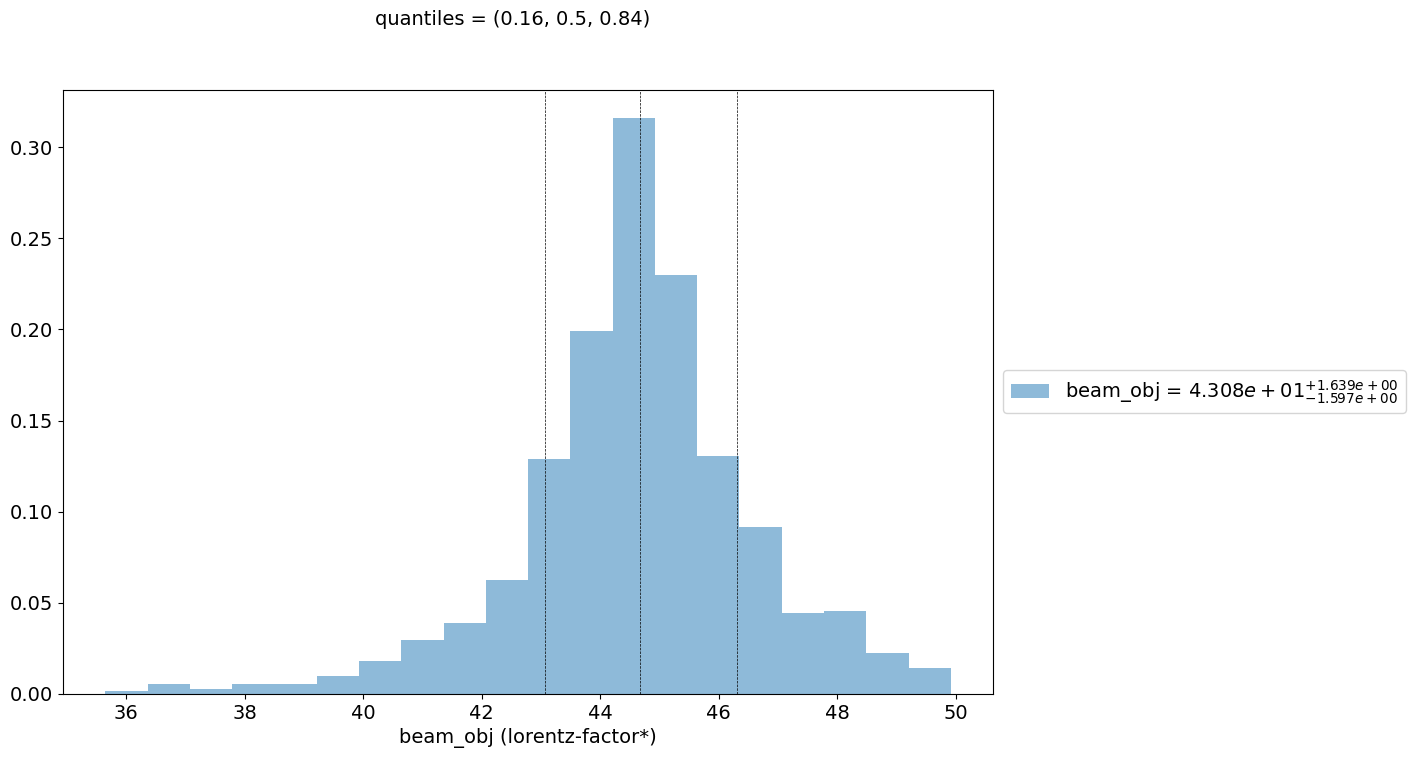

In [49]:
f=mcmc.plot_par('beam_obj')

## Save and reuse MCMC

In [50]:
mcmc.save('mcmc_sampler.pkl')

In [51]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_501.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

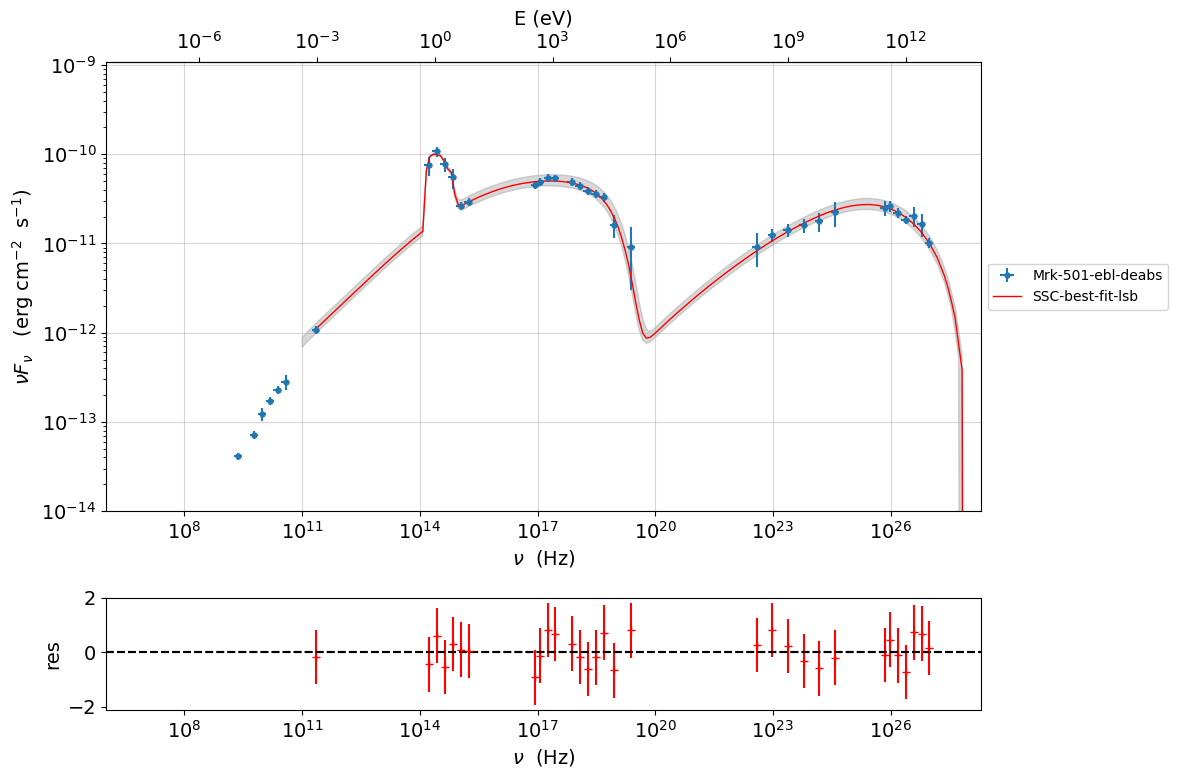

In [52]:
p=ms.plot_model(sed_data=sed_data,fit_range=[2E11, 2E28],size=50)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

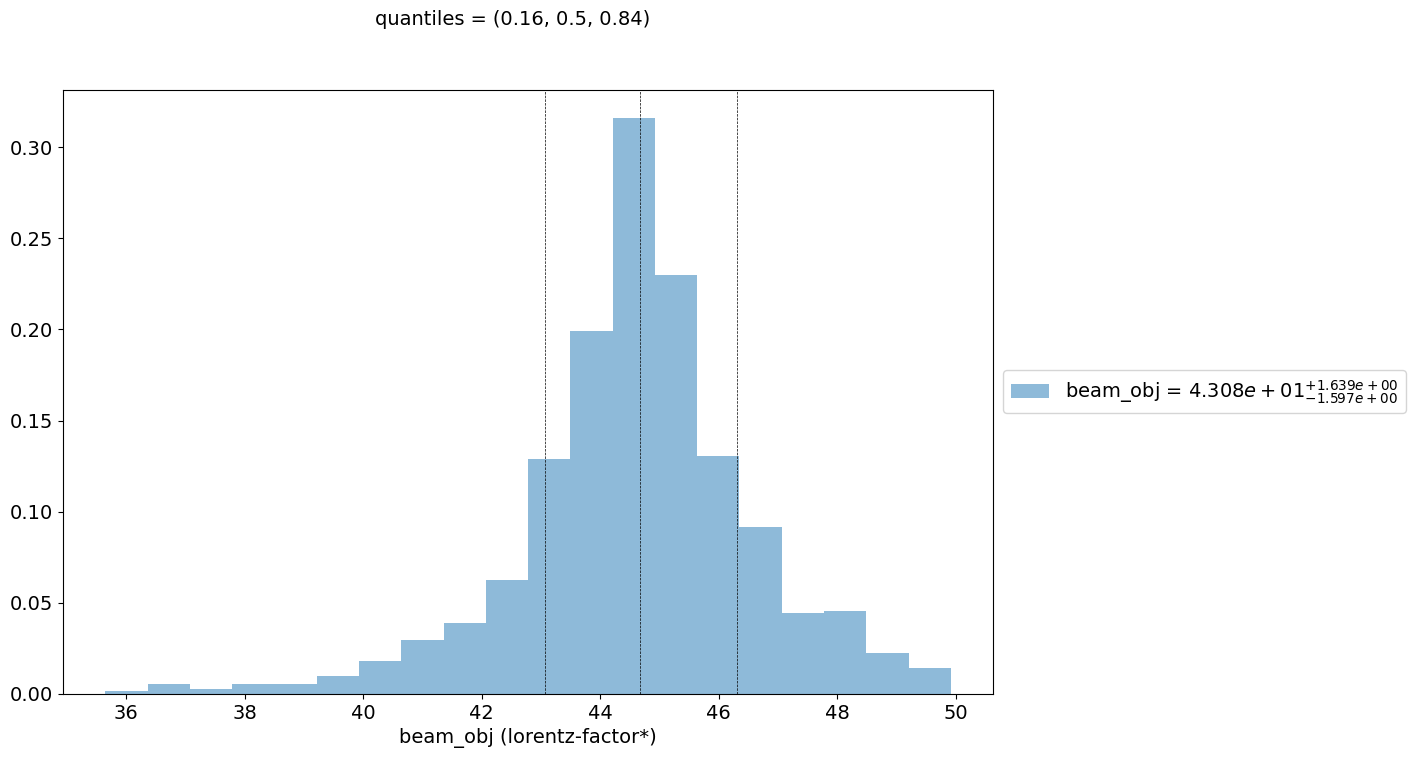

In [53]:
f=ms.plot_par('beam_obj',log_plot=False)


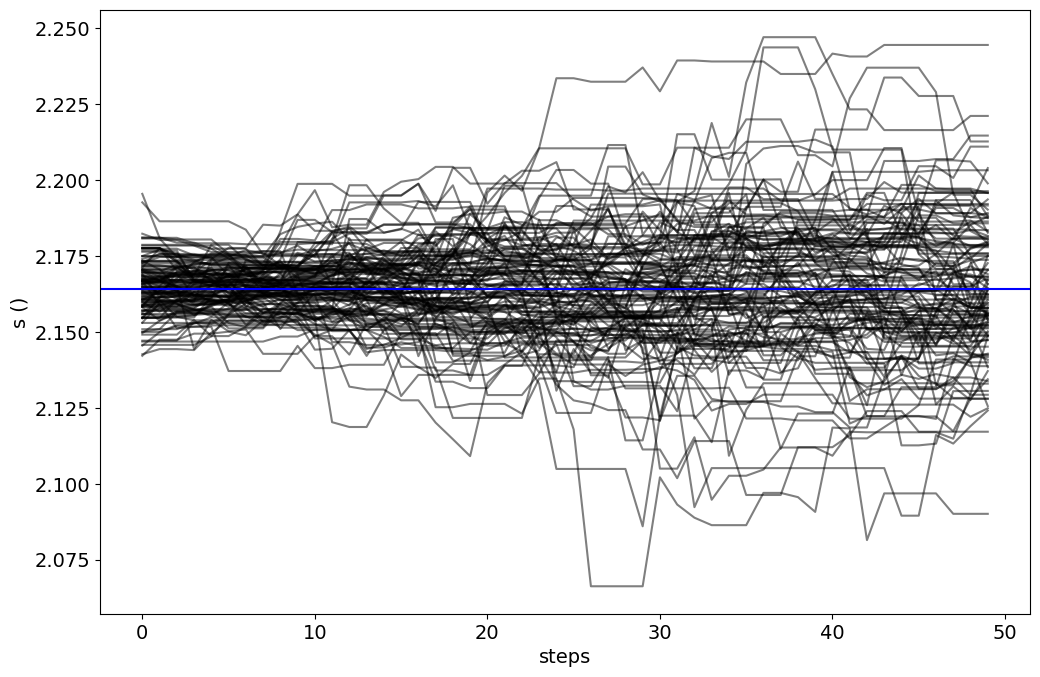

In [54]:
f=ms.plot_chain('s',log_plot=False)